<img src="../assets/logo.png">

Made by **Balázs Nagy**

[<img src="../assets/open_button.png">](https://colab.research.google.com/github/Fortuz/edu_MethodsAndTools/blob/main/practices/P14_EM/P14_EM.ipynb)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Motivation-for-Gaussian-Mixtures" data-toc-modified-id="Motivation-for-Gaussian-Mixtures-1">Motivation for Gaussian Mixtures</a></span></li><li><span><a href="#Derivation-of-Gaussian-Mixture" data-toc-modified-id="Derivation-of-Gaussian-Mixture-2">Derivation of Gaussian Mixture</a></span></li><li><span><a href="#Maximum-likelihood-for-Gaussian-Mixtures-&amp;-Derivation-of-the-EM-algorithm" data-toc-modified-id="Maximum-likelihood-for-Gaussian-Mixtures-&amp;-Derivation-of-the-EM-algorithm-3">Maximum likelihood for Gaussian Mixtures &amp; Derivation of the EM algorithm</a></span></li><li><span><a href="#How-does-the-EM-algorithm-work?" data-toc-modified-id="How-does-the-EM-algorithm-work?-4">How does the EM algorithm work?</a></span><ul class="toc-item"><li><span><a href="#1.-Initialization:" data-toc-modified-id="1.-Initialization:-4.1">1. Initialization:</a></span></li><li><span><a href="#2.-The-E-step:" data-toc-modified-id="2.-The-E-step:-4.2">2. The E step:</a></span></li><li><span><a href="#3.-The-M-step:" data-toc-modified-id="3.-The-M-step:-4.3">3. The M step:</a></span></li><li><span><a href="#4.--Evaluate-the-log-likelihood:" data-toc-modified-id="4.--Evaluate-the-log-likelihood:-4.4">4.  Evaluate the log likelihood:</a></span></li></ul></li><li><span><a href="#Implementation-(w/o-log-likelihood-evaluation)" data-toc-modified-id="Implementation-(w/o-log-likelihood-evaluation)-5">Implementation (w/o log likelihood evaluation)</a></span><ul class="toc-item"><li><span><a href="#Plotting-utils" data-toc-modified-id="Plotting-utils-5.1">Plotting utils</a></span></li><li><span><a href="#Example-1:-Simple-2d-Dataset" data-toc-modified-id="Example-1:-Simple-2d-Dataset-5.2">Example 1: Simple 2d Dataset</a></span></li><li><span><a href="#Example-2:-image-compression" data-toc-modified-id="Example-2:-image-compression-5.3">Example 2: image compression</a></span></li></ul></li><li><span><a href="#Sources:" data-toc-modified-id="Sources:-6">Sources:</a></span></li></ul></div>

# Motivation for Gaussian Mixtures
A single gaussian distribution is very limited for modeling data. With a gaussian mixture, a linear superposition of multiple gaussian distributions, one can often achieve a better characterization of the data.

$$ p(x) = \sum_{k=1}^{K} \pi _{k}N(x_{n}\mid\mu_{k}, \Sigma_{k}) $$
<img src="imgs/motivation.png" style="height:400px">



# Derivation of Gaussian Mixture

Example:
<img src="imgs/gaussian_mixture.png" style="height:300px">

**(a)** joint distribution $p(z)p(x|z)$ states of z corresponding to the colours => complete  

**(b)** $p(x)$ the observed data no more knowledge about the responsible latent variables => incomplete  

**(c)** colorur represent the responsibillities $\gamma(z_{nk}$ for each datapoint $x_n$  

# Maximum likelihood for Gaussian Mixtures & Derivation of the EM algorithm


# How does the EM algorithm work? 

EM is an iterative process that begins with some initialization and then alternates between the expectation and maximization steps until the algorithm reaches convergence. 

## 1. Initialization:

Initialize the means $\mu_k$, covariances $\Sigma_k$ and mixing coefficients $\pi_k$, and evaluate the initial value of the log likelihood.

It is common to run K-means first to find a suitable initialization for the EM algorithm. The covariance matricies $\Sigma_k$ can be initialized to the sample covariances of the clusters found by K-means. The mixing coefficients $\pi_k$ can be set to the fractions of data points assigned to the respective cluster, i.e. $$\pi_{k_{init}} = \frac{N_{k}}{N}$$


<img src="imgs/init.png" style="height:250px">

## 2. The E step:

We calculate the expected values $E(z_{ij})$, which is the probability that $x_i$ was drawn from the $jth$ distribution.
    
$$\gamma(z_{nk}) = \frac{\pi _{k}N(x_{n}\mid\mu_{k}, \Sigma_{k})}{\sum_{j=1}^{k}\pi _{j}N(x_{n}\mid\mu_{j}, \Sigma_{j})}$$

The formula simply states that the expected value for $z_{ij}$ is the probability $x_i$ given $\mu_j$ divided by the sum of the probabilities that $x_i$ belonged to each $\mu$

<img src="imgs/expectation.png" style="height:250px">

## 3. The M step:
Re-estimate the parameters using the current responsibilities

$$\mu_{k}^{new} = \frac{1}{N_{k}}\sum_{n=1}^{N}\gamma(z_{nk})x_{n}$$
$$\Sigma_{k}^{new} = \frac{1}{N_{k}}\sum_{n=1}^{N}\gamma(z_{nk})(x_{n}-\mu_{k}^{new})(x_{n}-\mu_{k}^{new})^{T}$$
$$\pi_{k}^{new} = \frac{N_{k}}{N}$$
where
$$N_{k} = \sum_{n=1}^{N}\gamma(z_{kn}).$$

By repeating the E-step and M-step we are guaranteed to increase the log likelihood, so it will converge to a local Maximum. This will be discussed in the third presentation.

<img src="imgs/maximization.png" style="height:250px">

## 4.  Evaluate the log likelihood:

$$ln\quad p(X\mid \mu ,\Sigma ,\pi ) = \sum_{n=1}^{N}ln\left \{ \sum_{k=1}^{k}\pi_{k}N(x_{n}\mid \mu_{k},\Sigma_{k}) \right \}$$

and check for convergence of either the parameters or the log likelihood. If the convergence criterion is not satisfied return to step 2.

<img src="imgs/convergence.png" style="height:250px">

# Implementation (w/o log likelihood evaluation)

In [1]:
import numpy as np
from scipy.stats import multivariate_normal

class EM:
    def __init__(self,X,clusters=2,init_cov_size=120):
        self.X = X
        self.clusters = clusters
        datapoints = self.X.shape[0]
        dims = self.X.shape[1]
        self.it = 0
        self.init_cov_size = init_cov_size
        
        # initialize with random points and identitiy matrices
        # self.cluster_centers = np.random.uniform(low=self.X.min(axis=0),
        #                                          high=self.X.max(axis=0),
        #                                          size=(self.clusters,self.X.shape[1]))
         
        # init means with random points from the data; seems to result in fewer singulartities
        rand = np.random.choice(datapoints, self.clusters,replace=False)
        self.cluster_centers = self.X[rand,:]
        
        self.cluster_covs = np.stack([np.eye(dims)*self.init_cov_size]*self.clusters,axis=0)
        self.mixing_coeffs = np.full(self.clusters,1/self.clusters)
        
    def fit(self,iterations=10):
        for i in range(iterations):  
            # Expectation
            self.responsibilities = self._expectation(self.X)
            # Maximization
            self._maximization()
            self.it += 1
        return self.cluster_centers, self.cluster_covs
    
    def _expectation(self,X):
        tripel = zip(self.cluster_centers,self.cluster_covs,self.mixing_coeffs)
        responsibilities = np.zeros((self.clusters,X.shape[0]))
        divisor_sum = np.zeros((X.shape[0]))
        
        for i,(mean,cov,mixing_coeff) in enumerate(tripel):
            resp = mixing_coeff * multivariate_normal.pdf(X,mean,cov,allow_singular=True)
            responsibilities[i] = resp
            divisor_sum += resp
        responsibilities /= divisor_sum
        return responsibilities

    
    def _maximization(self):
        X = self.X
        for i,resp in enumerate(self.responsibilities):
            Nk = resp.sum()
            if Nk <= 1:
                # catch near singularities
                print("Singularity detected")
                
                
                # choosing new mean uniformly random
                # new_mean = np.random.uniform(low=self.X.min(axis=0),
                #                              high=self.X.max(axis=0))
                
                # choosing random points form X as mean
                rand = np.random.choice(datapoints, self.clusters,replace=False)
                new_mean = X[rand,:]
                
                new_cov = np.eye(self.X.shape[1]) * self.init_cov_size
            else:
                new_mean = 1/Nk * (resp[:,np.newaxis]*X).sum(axis=0)
                unweighted_product = np.einsum('ji,jk->jik', (X-new_mean), (X-new_mean))
                cov_sum = (resp[:,np.newaxis,np.newaxis]*unweighted_product).sum(axis=0)
                new_cov = 1/Nk * cov_sum
            new_mixing_coeff = Nk/X.shape[0]
            
            self.cluster_centers[i] = new_mean
            self.cluster_covs[i] = new_cov
            self.mixing_coeffs[i] = new_mixing_coeff
                
    def predict(self,X):
        resp = self._expectation(X)
        cluster_prediction = resp.argmax(axis=0)
        prediction = np.copy(X)
        for i,mean in enumerate(self.cluster_centers):
            prediction[cluster_prediction==i] = mean
        return prediction
           

## Plotting utils

In [2]:
from numpy import pi, sin, cos
import matplotlib.pyplot as plt
%matplotlib inline

def oval(cov, num_points=100,radius=1):
    arcs = np.linspace(0, 2 * pi, num_points)
    x = radius * sin(arcs)
    y = radius * cos(arcs)
    
    xy = np.array(list(zip(x, y)))
    x, y = zip(*xy.dot(cov))
    return x,y

def make_plot(a):
    plt.figure(figsize=(6, 5))
    plt.title("EM iteration {}".format(a.it))

    colors = ['g', 'r', 'c', 'm', 'y', 'b' ]
    
    # selcect elements based on expectation
    x, y = zip(*X)
    try:
        plt.scatter(x, y, edgecolors="black",c=a.responsibilities[0],cmap='RdYlGn')
    except AttributeError:
        plt.scatter(x, y, edgecolors="black",color='y')
    for i in range(a.cluster_centers.shape[0]):
        # plot centers
        plt.scatter(a.cluster_centers[i,0],a.cluster_centers[i,1],s=250,color=colors[i],edgecolors="white")

        # plot ovals that show the shape of the  variances
        x, y = oval(a.cluster_covs[i],radius=2)
        x += a.cluster_centers[i,0]
        y += a.cluster_centers[i,1]
        plt.plot(x, y,linewidth=5,color=colors[i])

## Example 1: Simple 2d Dataset

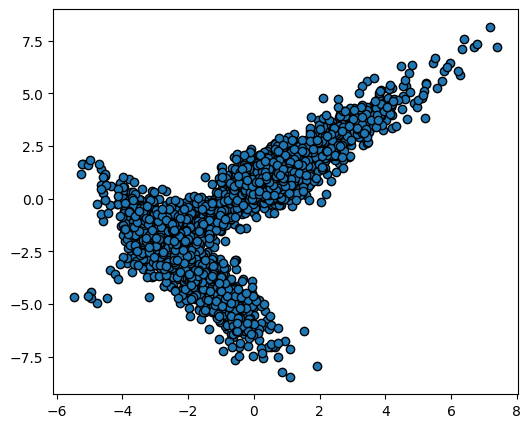

In [3]:
import numpy as np

# import dataset
X = np.loadtxt(open("2d-em.csv", "rb"), delimiter=",")
# plot dataset
x, y = zip(*X)
plt.figure(figsize=(6, 5))
plt.scatter(x, y, edgecolors="black")

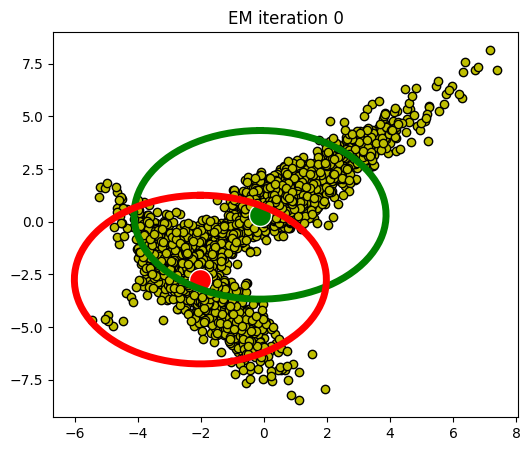

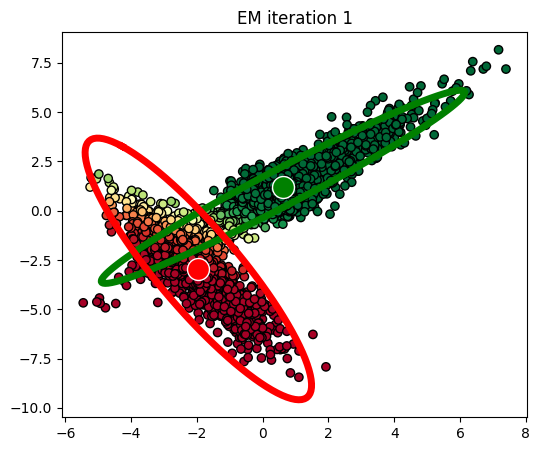

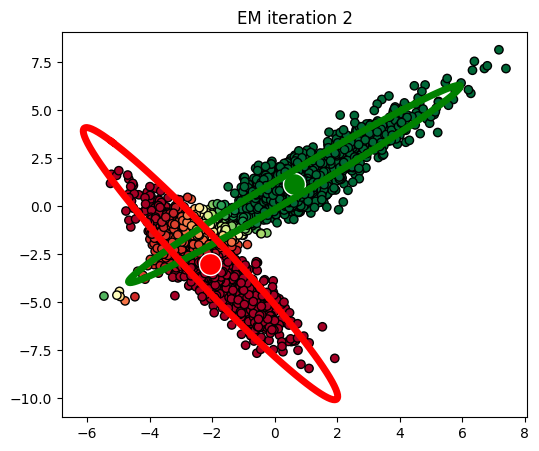

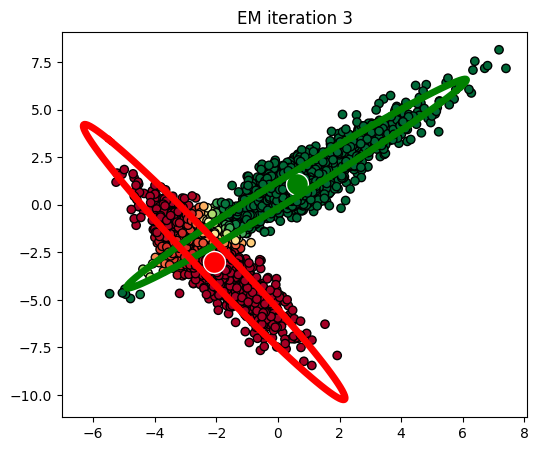

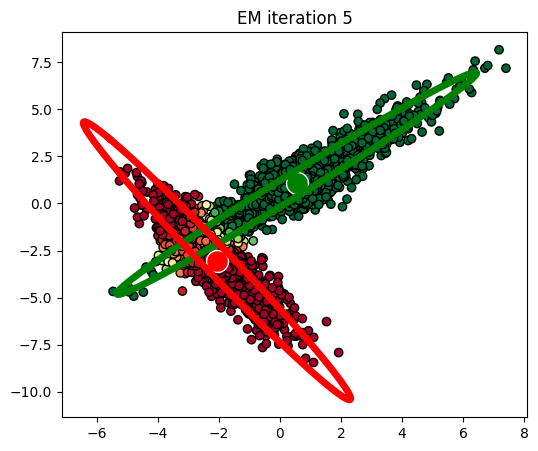

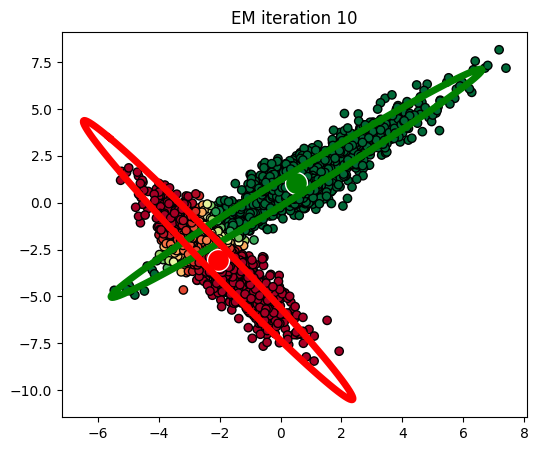

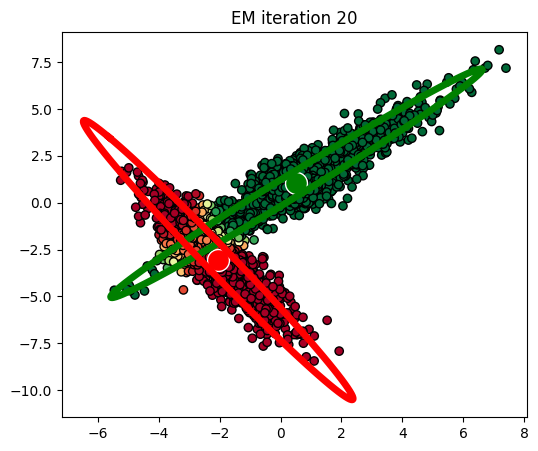

In [4]:
a = EM(X,2,init_cov_size=2)
for i in [1,1,1,2,5,10,10]:
    make_plot(a)
    mm = a.fit(i)

## Example 2: image compression

RGB Images nothing more than a large 2d matrix of pixels. Each Pixel takes three values between 0 and 255, corresponding to the intensity of the red, green, or blue colour channels. So In combination there are 255x255x255 possible different colour values for each pixel, resulting in a need for about 24 bits or 3 bytes per pixel. However, for most images a lot of pixels share nearly the same colors. Thus, we can use EM to find clusters of those colours that are distinct from each other and have a high occurence. The first image below is the original image. The second image is the compressed version, where we fit a gaussian mixture with 64 components/clusters w.r.t. the colours of the pixels in the original picture. To store the compressed picture one would only need 6 bits to represent the 64 diffentent compressed colours, resulting in a space reduction of ~75%.

In [5]:
import matplotlib.image as mpimg

def show_img(img):
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.show()

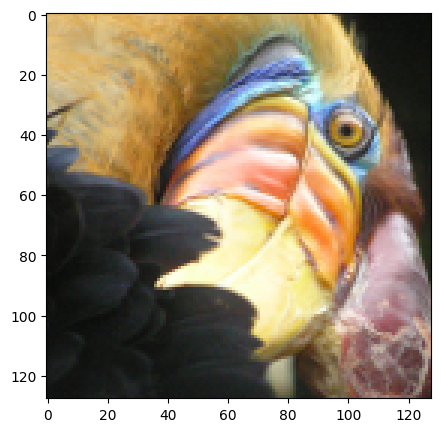

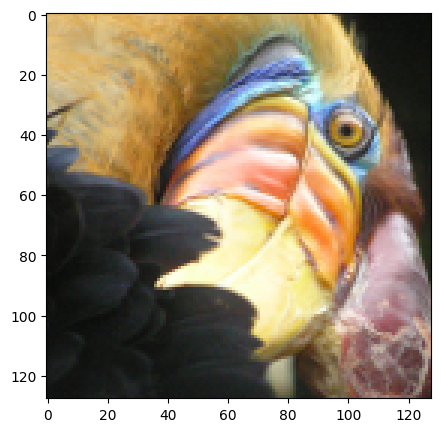

In [6]:
path = 'bird_small.png'
img = mpimg.imread(path)

from PIL import Image
from numpy import asarray
loaded_image = asarray(Image.open(path))

show_img(img)
show_img(loaded_image)

In [7]:
print(type(img))
print(np.max(img))
print(np.min(img))
print(img.shape)

<class 'numpy.ndarray'>
1.0
0.023529412
(128, 128, 3)


In [8]:
rows = img.shape[0]
cols = img.shape[1]

flat_img = img.reshape(img.shape[0] * img.shape[1], 3) #.astype(np.float)
cmpr = EM(flat_img, 2, init_cov_size=30)

In [9]:
a = cmpr.fit(5)

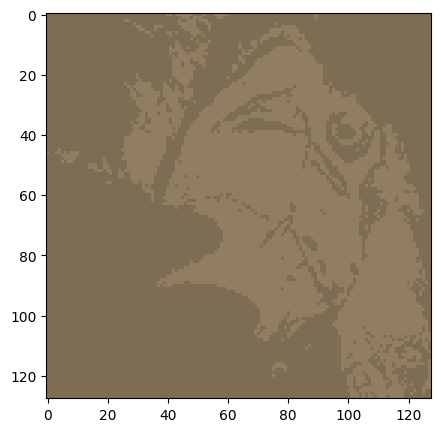

In [10]:
cmpr_img = (cmpr.predict(flat_img)).reshape(rows,cols, 3)
show_img(cmpr_img)

In [13]:
cmpr_img.shape

(128, 128, 3)

# Sources:
    - Bishop - Pattern Recognition And Machine Learning - Springer  2006 - Chapter 9.2
    - The Matrix Cookbook: http://www2.imm.dtu.dk/pubdb/views/edoc_download.php/3274/pdf/imm3274.pdf
    - https://math.stackexchange.com/questions/195911/covariance-of-gaussian-mixtures
    - https://github.com/volflow/Expectation-Maximization/tree/master
    